# magen2019 analysis
dataset contains scRNAseq data for tumor infiltrating cells but also LCMV Arm d7 control
first looking only at LCMV Arm data


In [3]:
import scanpy as sc #for scanpy >= 1.3.7
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import seaborn as sns

filepath = "C:/Users/Philipp/OneDrive/projects/2020/tcell_scRNAseq/data/magen_2019/"
data_path = "GSE124691_RAW/GSM3543444_Exp1_Arm_Gp66"
filepath = filepath+data_path

adata = sc.read_10x_mtx(filepath, cache = True)


scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.0
... writing an h5ad cache file to speedup reading next time


In [4]:
print(adata)
print('Total number of cells: {:d}'.format(adata.n_obs))

AnnData object with n_obs × n_vars = 2223 × 27998
    var: 'gene_ids'
Total number of cells: 2223


# Comparing manual quality control with built in API function for QC metrics
results are slightly similar but agree overall. API function might suffice to do this

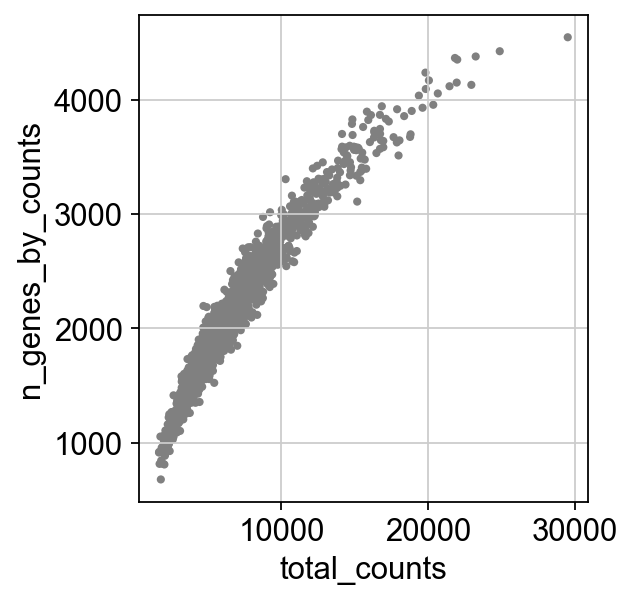

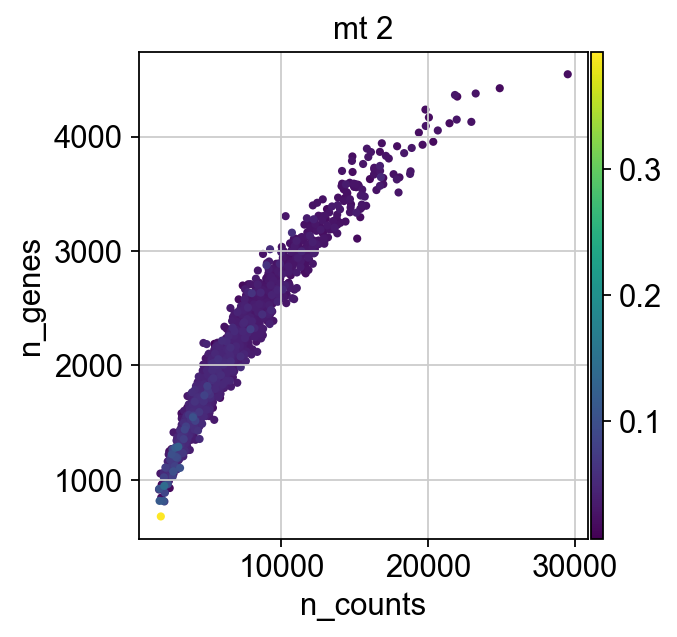

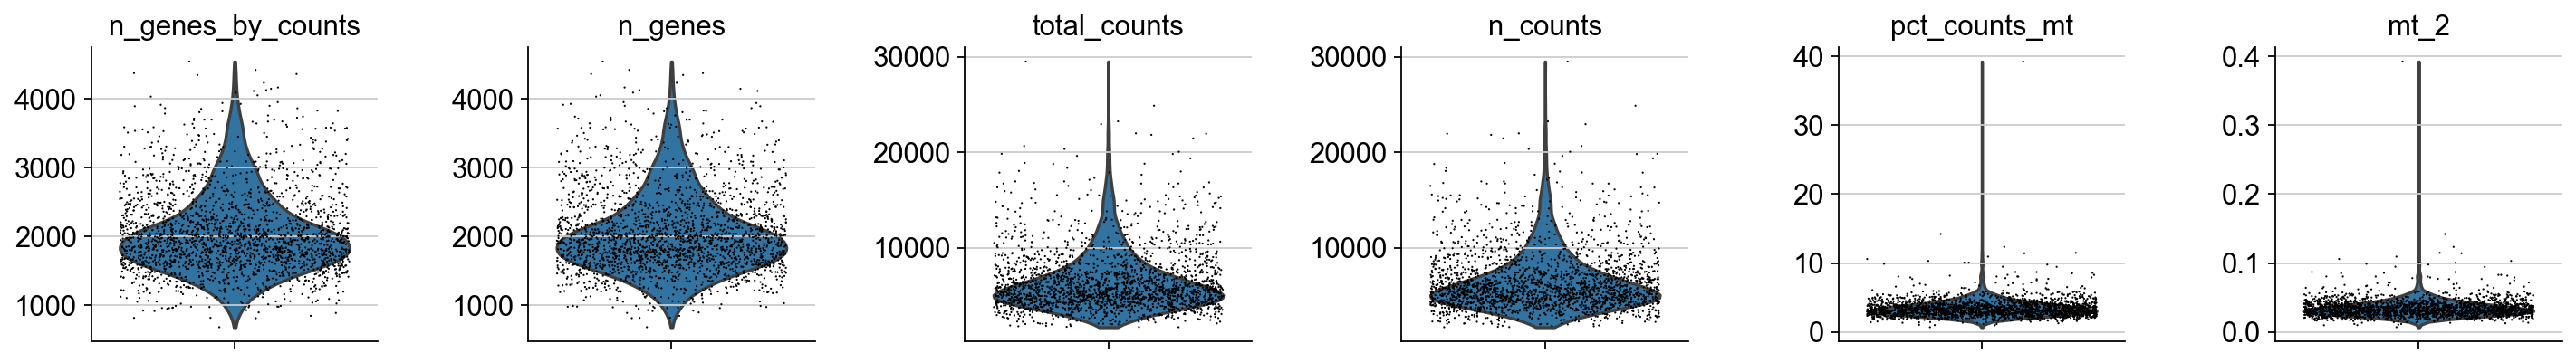

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'

# calculate quality control metrics by hand
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_2'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

# calculate quality control metrics using api function
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_counts', y='n_genes', color = "mt_2")

sc.pl.violin(adata, ['n_genes_by_counts', "n_genes", 'total_counts', "n_counts", 'pct_counts_mt', "mt_2"],
             jitter=0.4, multi_panel=True)

# data seems preprocessed, low mito content and few outlier in general
based on above visualizations I assume that data is provided in the way that it was used in original paper, so no further filtering applied

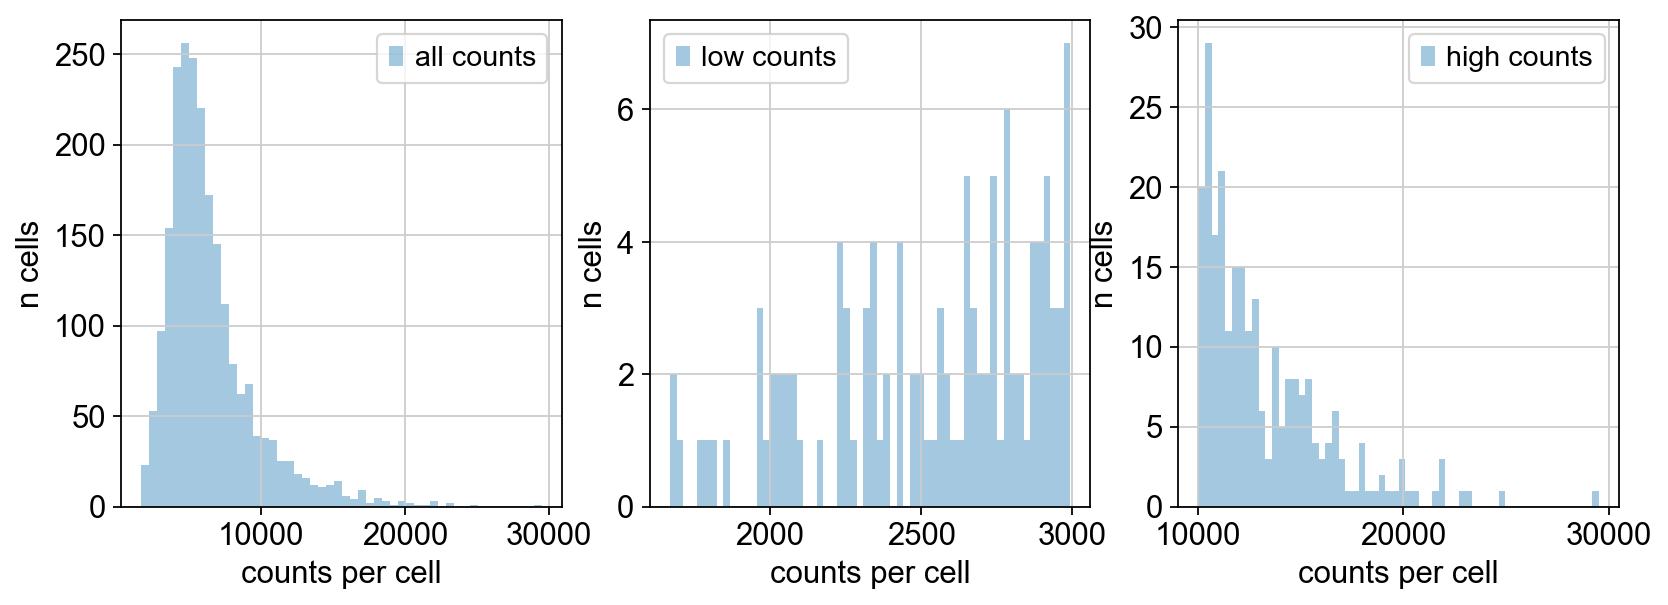

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

observable= "n_counts"
filter_hi = 10000
filter_lo = 3000

p1 = sns.distplot(adata.obs[observable], 
                 kde=False, 
                 ax=ax1, label = "all counts")
p2 = sns.distplot(adata.obs[observable][adata.obs[observable]<filter_lo], 
                 kde=False, bins=60, 
                 ax=ax2, label = "low counts")
p3 = sns.distplot(adata.obs[observable][adata.obs[observable]>filter_hi], 
                 kde=False, bins=60, 
                 ax=ax3, label = "high counts")
for ax in [ax1, ax2, ax3]:
    ax.legend()
    ax.set_ylabel("n cells")
    ax.set_xlabel("counts per cell")
plt.show()

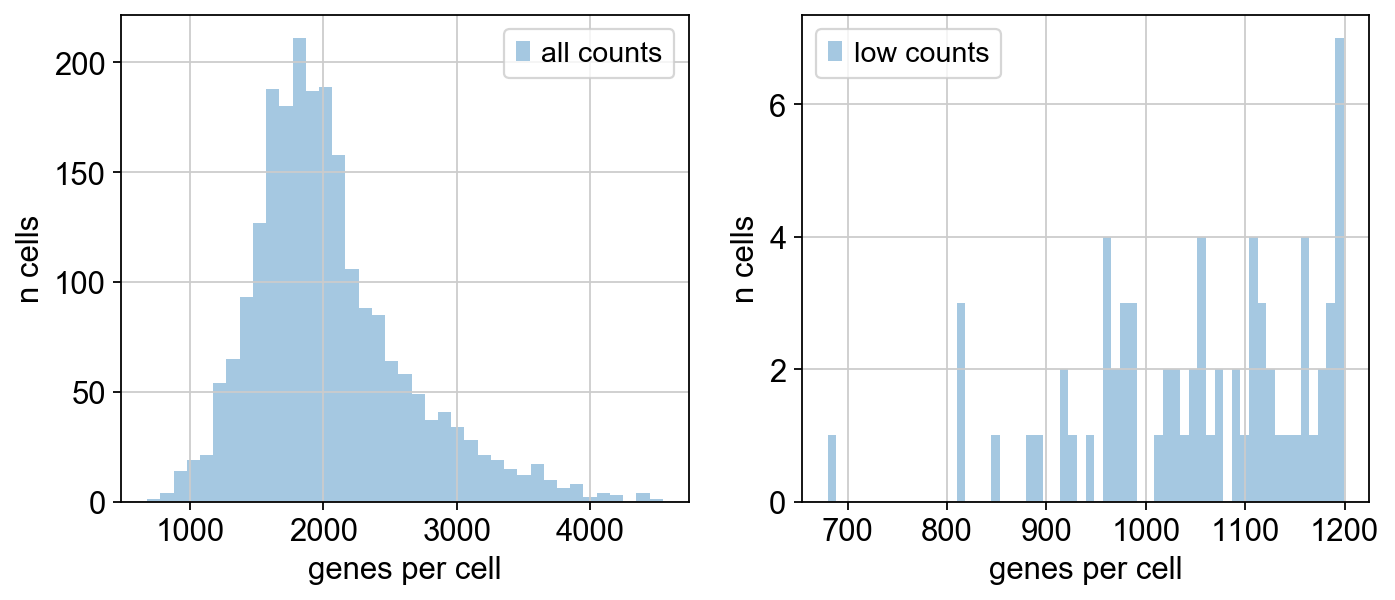

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

observable= "n_genes"
filter_lo = 1200

p1 = sns.distplot(adata.obs[observable], 
                 kde=False, 
                 ax=ax1, label = "all counts")
p2 = sns.distplot(adata.obs[observable][adata.obs[observable]<filter_lo], 
                 kde=False, bins=60, 
                 ax=ax2, label = "low counts")

for ax in [ax1, ax2]:
    ax.legend()
    ax.set_ylabel("n cells")
    ax.set_xlabel("genes per cell")
plt.show()

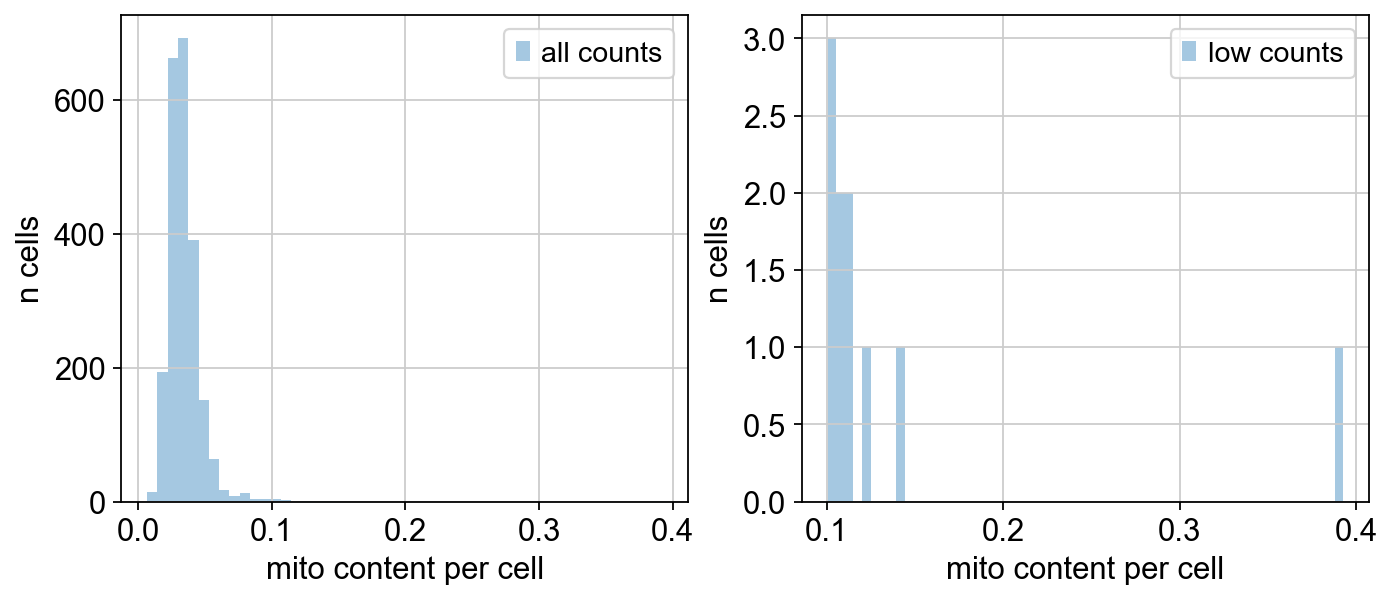

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

observable= "mt_2"
filter_hi = 0.1

p1 = sns.distplot(adata.obs[observable], 
                 kde=False, 
                 ax=ax1, label = "all counts")
p2 = sns.distplot(adata.obs[observable][adata.obs[observable]>filter_hi], 
                 kde=False, bins=60, 
                 ax=ax2, label = "low counts")

for ax in [ax1, ax2]:
    ax.legend()
    ax.set_ylabel("n cells")
    ax.set_xlabel("mito content per cell")
plt.show()

# no further filtering based on QC metrics

In [9]:
savepath = "C:/Users/Philipp/OneDrive/projects/2020/tcell_scRNAseq/output/cleaned_datasets/"
adata.write(savepath+"anndata_filtered_magen_2019.h5ad")

# Normalization

In [7]:
# normalize library size for each cell by dividing over total counts per cell and multiply by 1e6
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata) # log
#Set the .raw attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations 
#of gene expression. This simply freezes the state of the AnnData object.
adata.raw = adata


normalizing counts per cell
    finished (0:00:00)


# highly variable genes (used for PCA)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


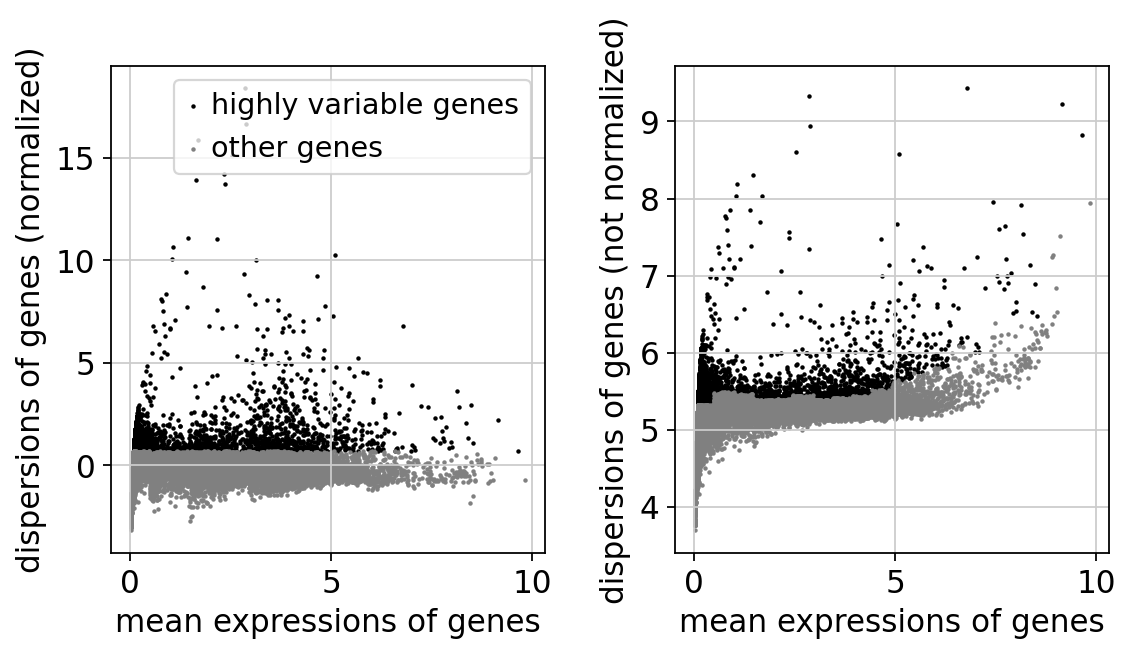

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
sc.pl.highly_variable_genes(adata)

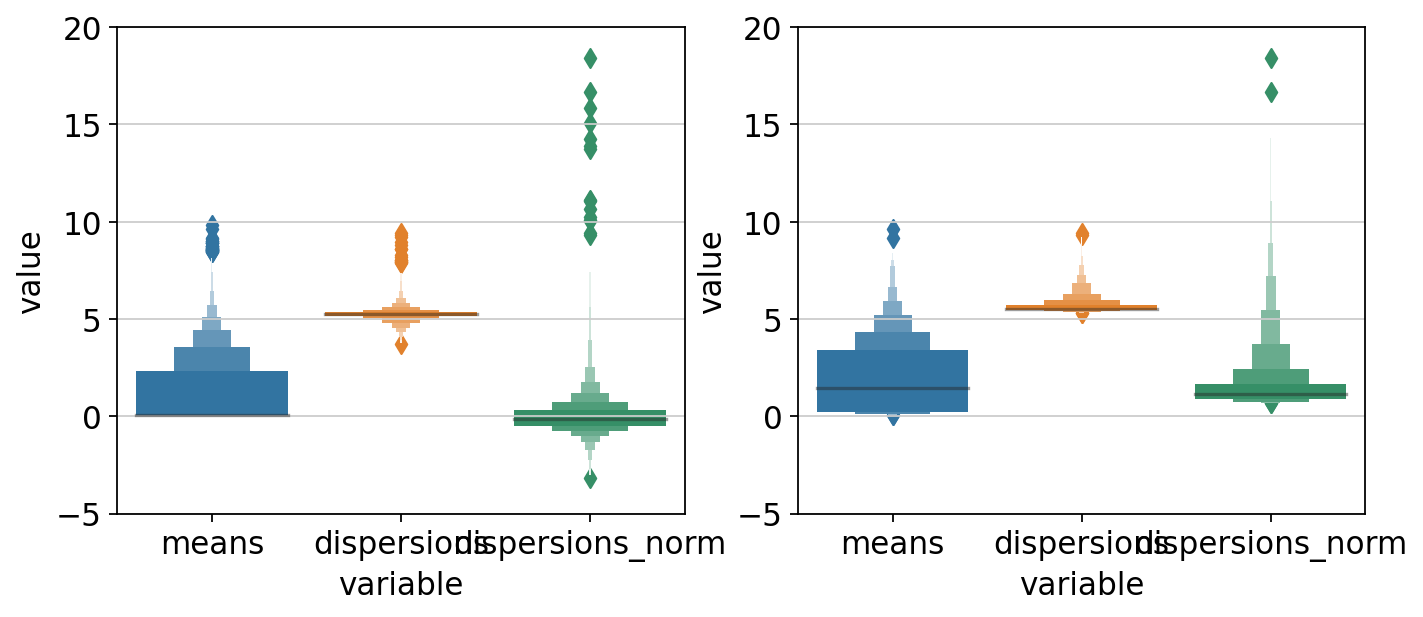

In [9]:
df = adata.var[["highly_variable", "means", "dispersions", "dispersions_norm"]]
df2 = df.melt(id_vars = ["highly_variable"])
df_var = df2[df2.highly_variable == True]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
sns.boxenplot(data = df2, x = "variable", y = "value", ax = ax1)
sns.boxenplot(data = df_var, x = "variable", y = "value", ax = ax2)

ylim = (-5,20)
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)

df2.to_csv("../output/variance_magen_2019.csv")

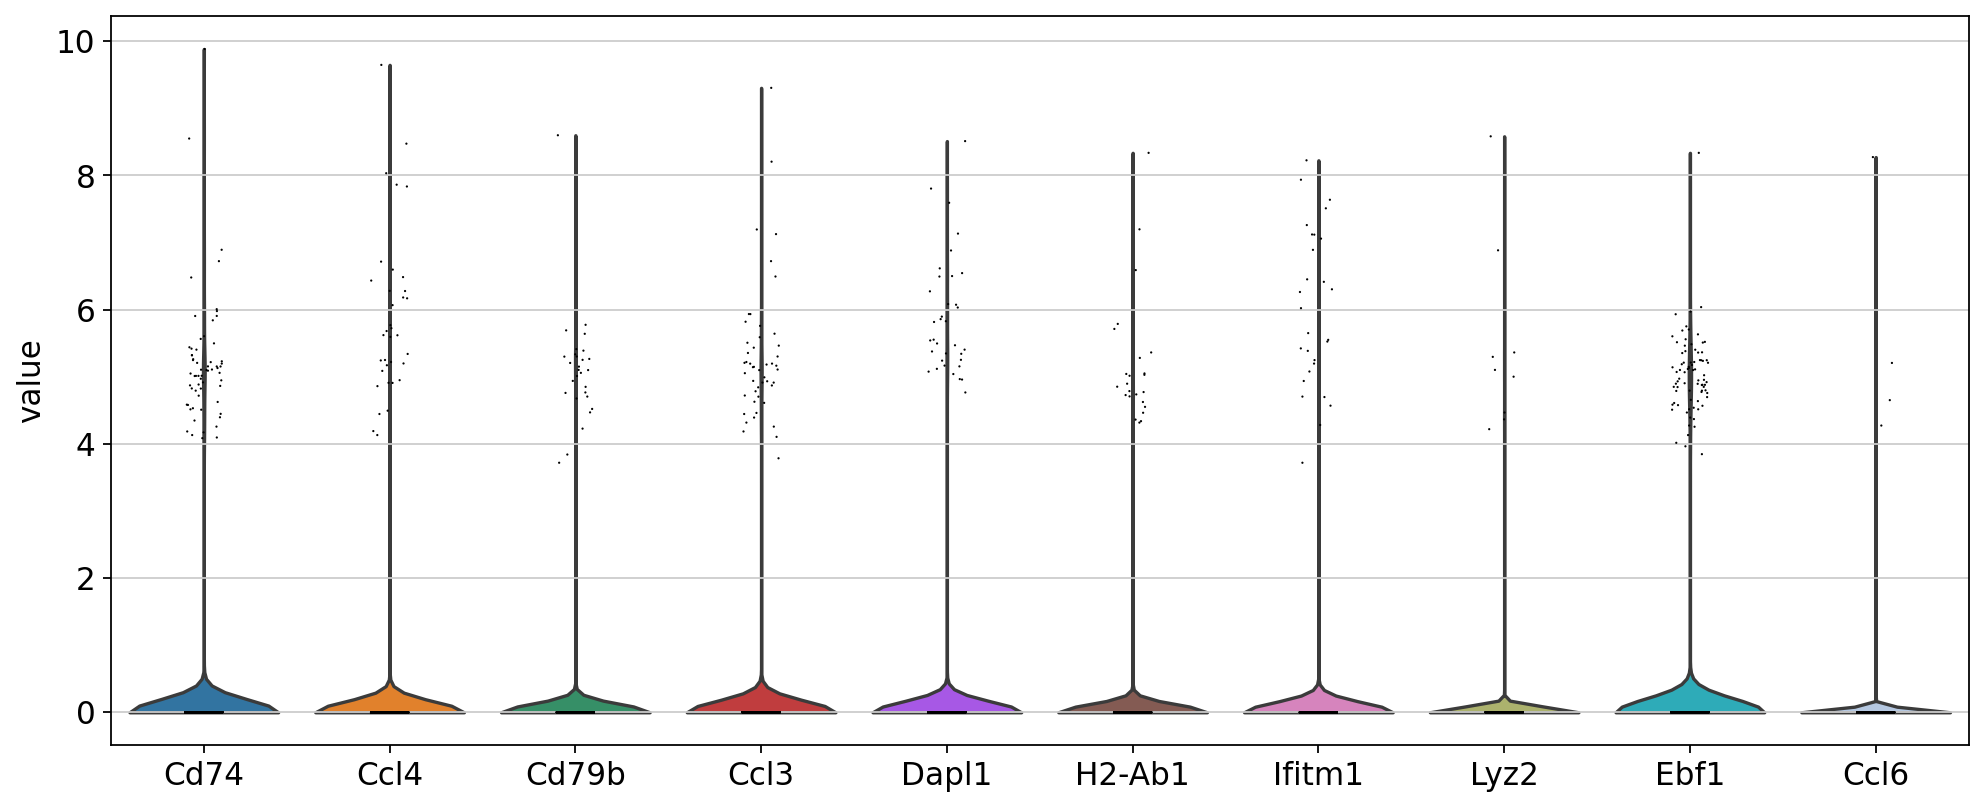

In [29]:
# find the top variable genes
#df.sort_values(by = "dispersions_norm", ascending = False)
#top_var_genes = df.index.values
#top_var_genes = top_var_genes[:10]
df_sorted = df.sort_values(by = "dispersions_norm", ascending = False)
genes_sorted = df_sorted.index.values
top_var_genes = genes_sorted[:10]

rcParams['figure.figsize']=(12,6)
sc.pl.violin(adata, top_var_genes)

In [ ]:
adata = adata[:, adata.var.highly_variable]

# PCA and UMAP

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


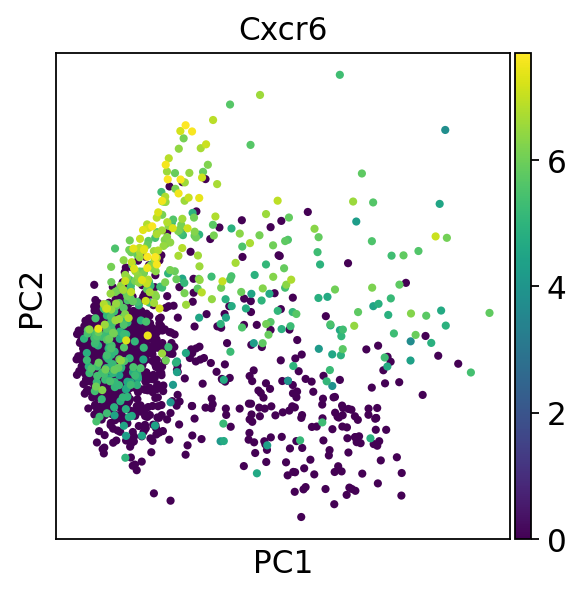

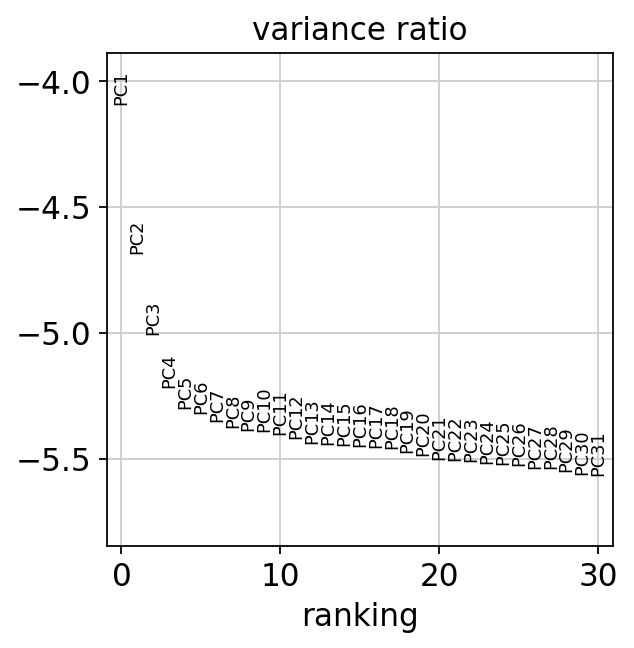

In [10]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='Cxcr6')
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:08)


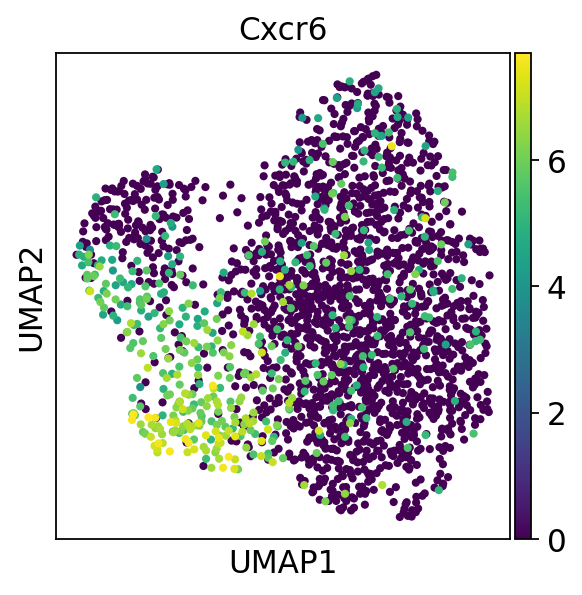

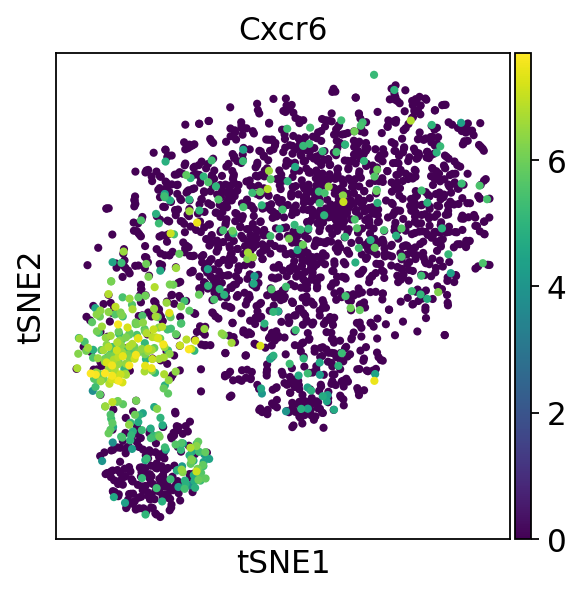

In [11]:
# use only top 10 PCs for neighborhood graph which is then used for UMAP
# nPCs comes from methods Ciucci paper
n_pcs = 10
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_pcs)
sc.tl.umap(adata)
sc.tl.tsne(adata, n_pcs = n_pcs)
sc.pl.umap(adata, color=['Cxcr6'])
sc.pl.tsne(adata, color=['Cxcr6'])

running Leiden clustering
    finished: found 8 clusters and added
    'leiden_res0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res0.7', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_res1', the cluster labels (adata.obs, categorical) (0:00:00)


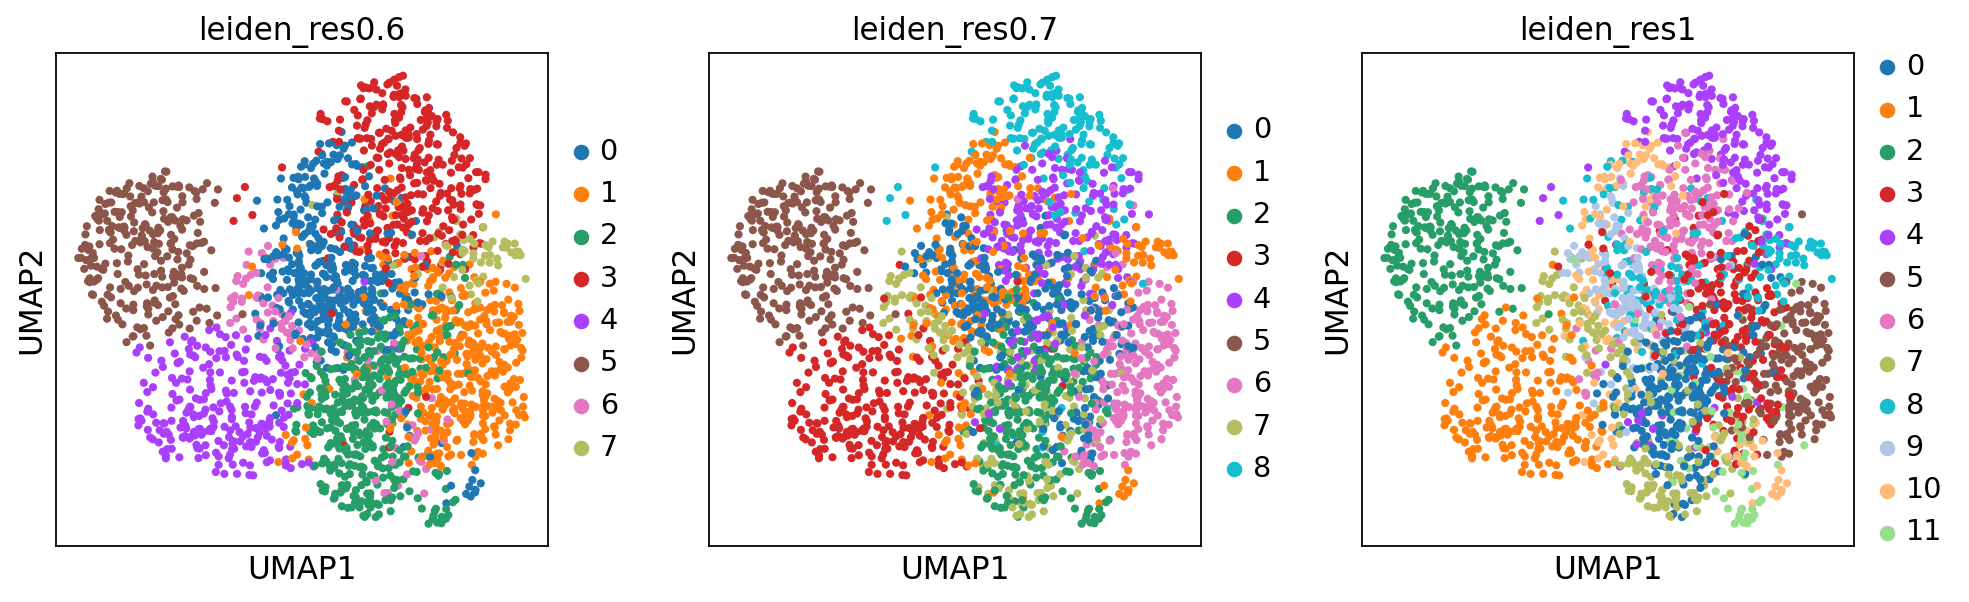

In [12]:
res = [0.6, 0.7, 1]
key = "leiden_res"
keys_2 = [str(x) for x in res]
all_keys = [key+x for x in keys_2]

for val, key in zip(res, all_keys):
    sc.tl.leiden(adata, resolution = val, key_added = key)

sc.pl.umap(adata, color=all_keys)